# CLUSTERING SMART METER DATA TUTORIAL 

### This notebook was created by Miha Grabner and serves as an appendix to this [blog](https://www.mihagrabner.com/post/tutorial-clustering-energy-data-from-smart-meters).
#### If you want to see more, please visit [mihagrabner.com](https://www.mihagrabner.com/) or a LinkedIn group [AI in Smart Grids](https://www.linkedin.com/groups/13621702/).
#### If you like my work please share it with others!

# NOTEBOOK DESCRIPTION
In this notebook, I will guide you through three types of smart meter data clustering:
- clustering daily profiles of multiple consumers,
- clustering daily mean profiles of multiple consumers,
- clustering weekly mean profiles of multiple consumers.

# LIBS

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = "w"

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA

- hh name of a `pd.DataFrame` reffers to households.
- every column contains a load time series in kW with hourly resolution for a particular consumer from 2018-1-1 until 2018-3-21
- there are 90 days of data with hourly resolution (number of rows: 90 * 24 = 2160)
- there are 100 consumers (number of columns: 100)

In [9]:
hh = pd.read_csv("smartmeters_dataset.csv", 
                 index_col=0, 
                 parse_dates=True)
hh.index.name = "timestamp"
hh.columns.name = "cons_id"
print("Dataset shape:", hh.shape)

# OTHER
x_axis = pd.date_range("2017-1-1", periods=24, freq="1h").strftime("%H:%M")
weekday_names = ["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"]

hh.head(2)

Dataset shape: (2160, 100)


cons_id,cons_0,cons_1,cons_2,cons_3,cons_4,cons_5,cons_6,cons_7,cons_8,cons_9,...,cons_90,cons_91,cons_92,cons_93,cons_94,cons_95,cons_96,cons_97,cons_98,cons_99
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29,0.077,0.206,0.160,0.353,0.263,0.104,0.265,0.032,0.129,...,0.261,0.355,0.417,0.359,0.277,0.214,0.568,0.057,0.280,0.549
2018-01-01 01:00:00,0.35,0.059,0.248,0.284,0.710,0.363,0.143,0.246,0.068,0.119,...,0.335,0.465,0.506,0.374,0.214,0.314,0.315,0.063,0.412,0.581


# HELPER FUNCTIONS 
For now, run the cell below and skip to the next cell. You can come back later and break down the code.

In [10]:
def reshape2daily(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe with daily resolution, 
                 where every column contains data for a particular hour & different consumers are stacked verticaly.
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = df_in.unstack().reset_index()
    df = (pd.pivot_table(df, 
                         values=0, 
                         index=[df.timestamp.dt.to_period("D"), df.cons_id],   
                         columns=df.timestamp.dt.strftime("%H:%M")
                         )
            .reset_index()
            .sort_values(["cons_id", "timestamp"])
            .set_index("timestamp")
         )
    return df


def reshape2weekly(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe, 
                 where every consumer has a weekly mean profile in each row. 
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = df_in.unstack().reset_index()
    df = (pd.pivot_table(df, 
                         values=0, 
                         index=df.cons_id,
                         columns=[df.timestamp.rename("dayofweek").dt.dayofweek, 
                                  df.timestamp.rename("hour").dt.hour]
                         )
            .round(3)
         )
    return df


def normalize_df(df):
    """
    DESCRIPTION: Normalizes input dataframe according to daily maximum.
    """
    # fillna is for profiles with only zeros per day
    return df.apply(lambda s: s / df.max(axis=1)).fillna(0)


def plot_cost_vs_clusters(df, max_clusters=10):
    """
    DESCRIPTION: Fits KMeans for different number of clusters & plots cost depending on a number of clusters.
    """
    inertias = []

    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters).fit(df)
        inertias.append(kmeans.inertia_)

    inertias = pd.Series(inertias, index=list(range(2, max_clusters+1)))
    inertias.plot(grid=True);
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost");
    
    
def plot_cluster_centroids(df, clust, lw=4, alpha=0.6):
    """
    DESCRIPTION: Plots cluster centroids.
    """
    
    weekly = False if df.shape[1] < 168 else True
    figsize = [15, 4] if weekly else [8, 6]
    
    fontsize = 15
    fig = plt.figure(figsize=figsize)
    
    df.assign(clust=clust).groupby("clust").mean().T.plot(ax=plt.gca(), lw=lw, alpha=alpha);

    plt.title("Cluster Centroids", fontsize=fontsize+5);
    plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=fontsize);
    
    if weekly:
        plt.xticks(np.arange(0, df.shape[1], 24), 
                   weekday_names, 
                   fontsize=fontsize);
    
    plt.yticks(fontsize=fontsize);
    plt.xlabel("")
    plt.ylabel("$P/P_{max}$", fontsize=fontsize)
    plt.legend(title="Cluster centroids:", loc="upper left")
    plt.grid()


def plot_clustered_profiles(df, clust, n_cols=3, alpha=0.2):
    """
    DESCRIPTION: Plots one subplot per cluster, where each subplot contains
                    all profiles in a particular cluster together with a cluster centroid.
    """

    weekly = False if df.shape[1] < 168 else True
    clust_perc = 100 * clust.value_counts(normalize=True)

    n_rows = np.ceil(clust.nunique() / n_cols)
    fontsize = 15

    fig = plt.figure(figsize=[15, n_rows*4])

    for i, clust_n in enumerate(clust_perc.index):

        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df_plot = df[clust == clust_n]
        
        step = 10 if df_plot.shape[0] > 500 else 1  # plot less profiles

        plt.plot(df_plot.iloc[::step].T.values, alpha=alpha, color="dodgerblue")
        df_plot.mean().plot(ax=plt.gca(), alpha=1, color="k", legend=False);

        plt.title("clust: {}, perc: {:.1f}%".format(clust_n, 
                                                    clust_perc.loc[clust_n]), 
                                                    fontsize=fontsize+5);
        plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=12);
        
        if weekly:
            plt.xticks(np.arange(0, df.shape[1], 24), 
                       weekday_names, 
                       fontsize=fontsize);
        
        plt.yticks(fontsize=fontsize);

        plt.xlabel("Hours", fontsize=fontsize)
        plt.ylabel("$P/P_{max}$", fontsize=fontsize)
        plt.grid()

    plt.tight_layout()

# CREATE INPUT MATRICES

In the cell below, the following input dataframes will be created:
- `X_daily` representing daily consumer profiles for all consumers.
- `X_daily_mean_workingdays` representing daily mean consumer profiles (working days).
- `X_daily_mean_weekends` representing daily mean consumer profiles (weekends).
- `X_weekly_mean` representing weekly mean consumer profiles. <br>

Next, the normalized versions will be created by dividing every row with it's maximum value (daily/weekly normalization).

In [11]:
X_daily = reshape2daily(hh)
X_daily_norm = (normalize_df(X_daily.loc[:, X_daily.columns.difference(["cons_id"])])
                            .round(3))
print("X_daily_norm shape:", X_daily_norm.shape)

X_daily_mean_workingdays = X_daily.loc[X_daily.index.dayofweek < 5].groupby("cons_id").mean()
X_daily_mean_workingdays_norm = normalize_df(X_daily_mean_workingdays).round(3)
print("X_daily_mean_workingdays_norm shape:", X_daily_mean_workingdays_norm.shape)

X_daily_mean_weekends = X_daily.loc[X_daily.index.dayofweek >= 5].groupby("cons_id").mean()
X_daily_mean_weekends_norm = normalize_df(X_daily_mean_weekends).round(3)
print("X_daily_mean_weekends_norm shape:", X_daily_mean_weekends_norm.shape)

X_weekly_mean = reshape2weekly(hh)
X_weekly_mean_norm = normalize_df(X_weekly_mean)
print("X_weekly_mean_norm shape:", X_weekly_mean_norm.shape)

X_daily_norm shape: (9000, 24)
X_daily_mean_workingdays_norm shape: (100, 24)
X_daily_mean_weekends_norm shape: (100, 24)
X_weekly_mean_norm shape: (100, 168)


# Task 1: Clustering daily profiles

## Determine the number of clusters

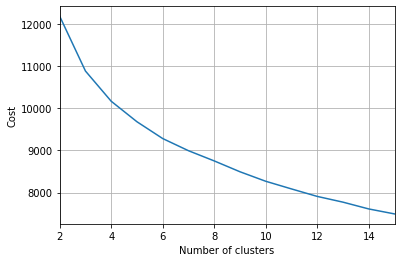

In [301]:
plot_cost_vs_clusters(X_daily_norm, max_clusters=15)

## Calculate clusters

In [302]:
n_clusters = 9

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_norm)
clust = pd.Series(model.labels_, index=X_daily_norm.index)

## Plot Results

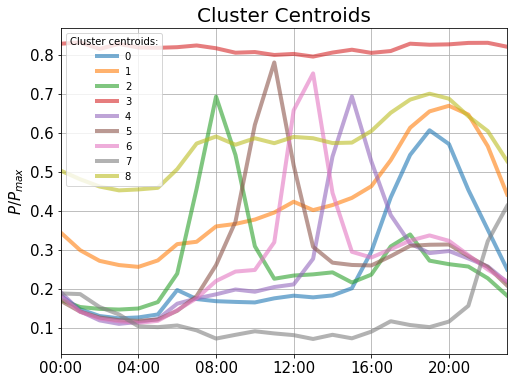

In [305]:
plot_cluster_centroids(X_daily_norm, clust)

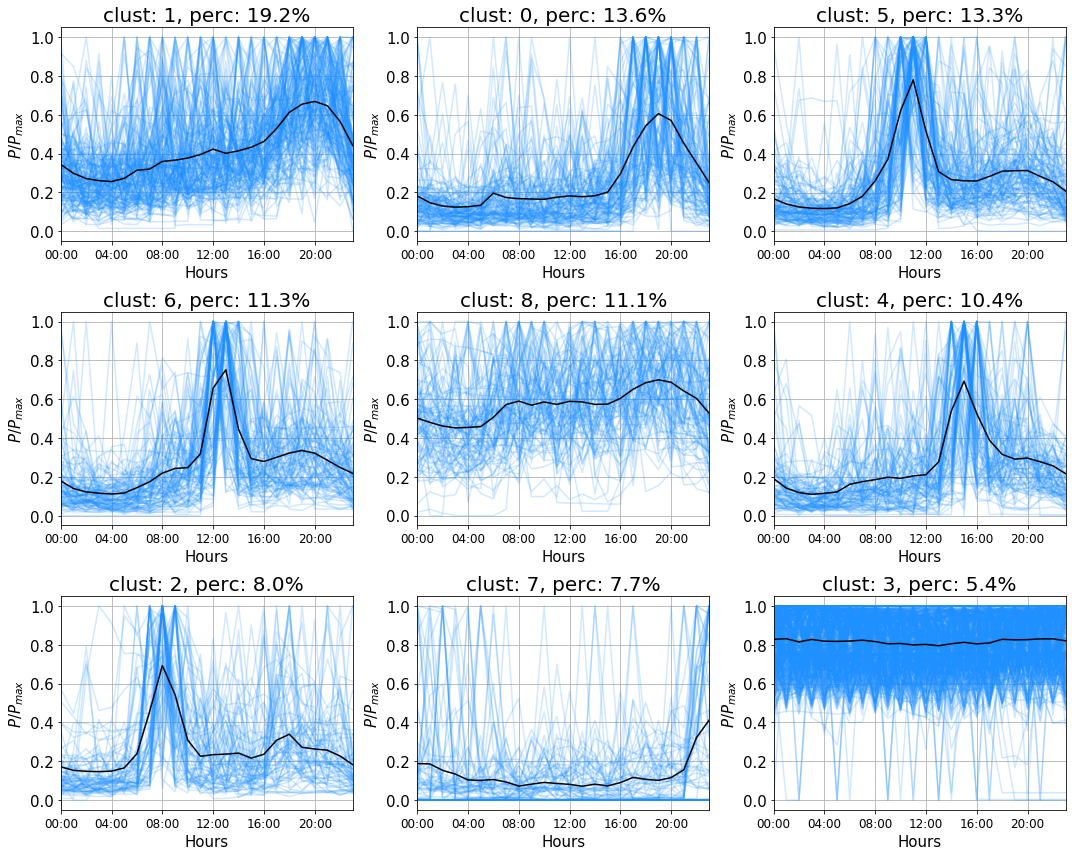

In [306]:
plot_clustered_profiles(X_daily_norm, clust)

# Task 2: Clustering mean daily profiles

## Task 2.1: Working days

## Determine the number of clusters

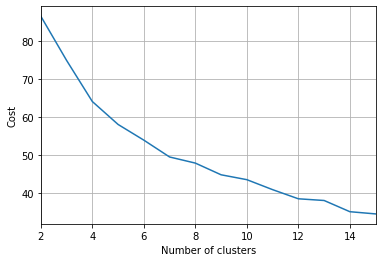

In [307]:
plot_cost_vs_clusters(X_daily_mean_workingdays_norm, max_clusters=15)

## Calculate clusters

In [325]:
n_clusters = 6

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_mean_workingdays_norm)
clust = pd.Series(model.labels_, index=X_daily_mean_workingdays_norm.index)

## Plot Results

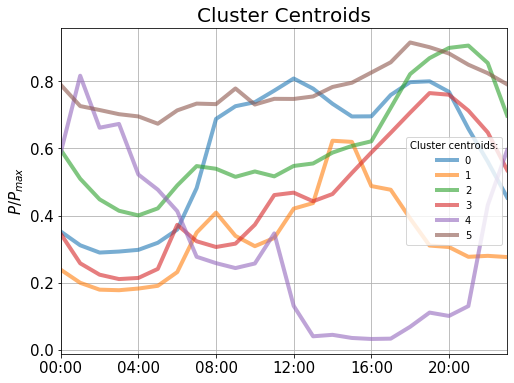

In [326]:
plot_cluster_centroids(X_daily_mean_workingdays_norm, clust)

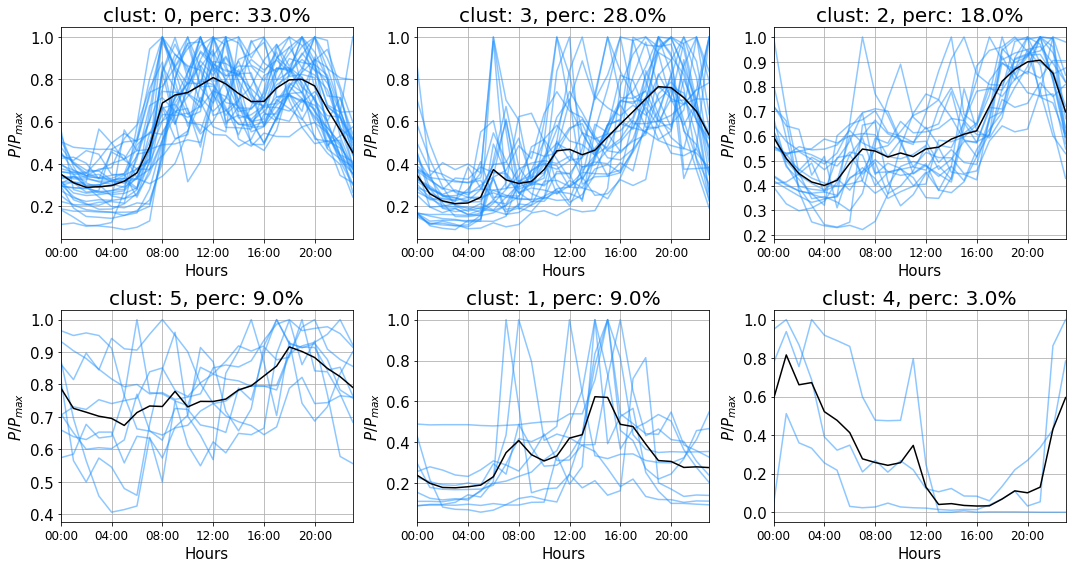

In [327]:
plot_clustered_profiles(X_daily_mean_workingdays_norm, clust, alpha=0.5)

## Task 2.2: Weekends

## Determine the number of clusters

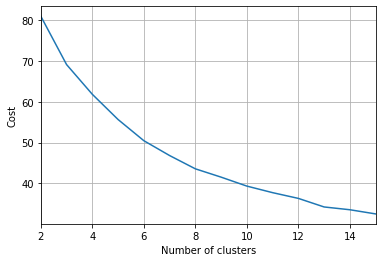

In [311]:
plot_cost_vs_clusters(X_daily_mean_weekends_norm, max_clusters=15)

## Calculate clusters

In [322]:
n_clusters = 6

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_mean_weekends_norm)
clust = pd.Series(model.labels_, index=X_daily_mean_weekends_norm.index)

## Plot Results

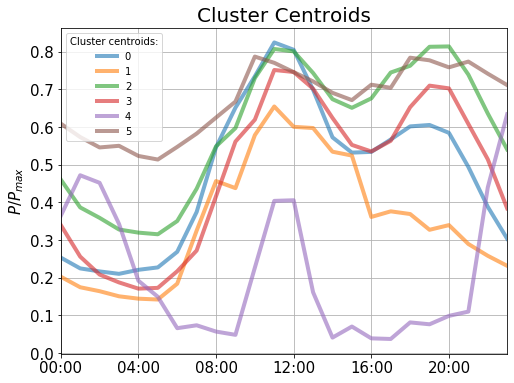

In [329]:
plot_cluster_centroids(X_daily_mean_weekends_norm, clust)

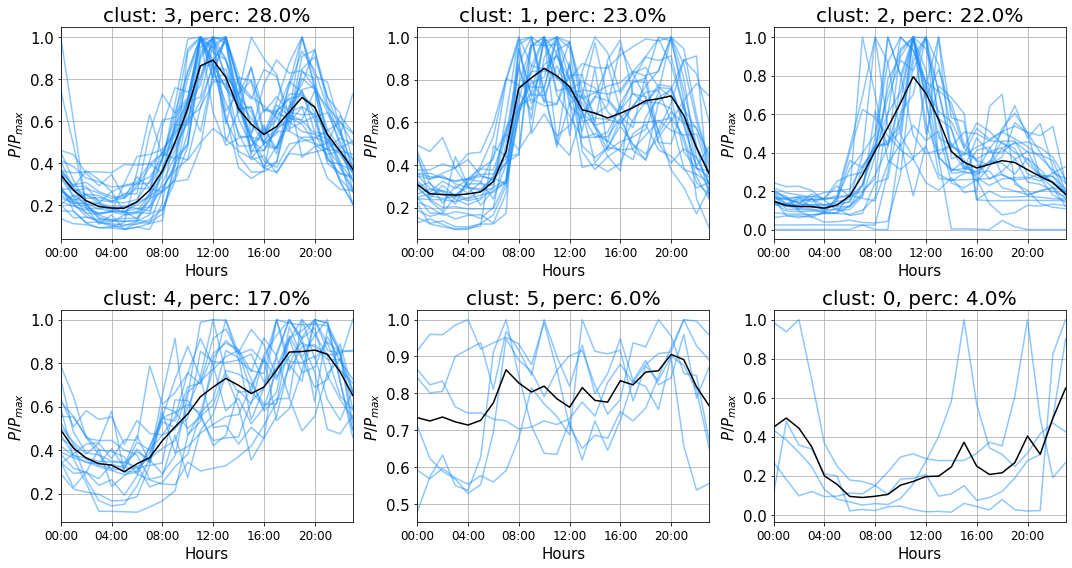

In [323]:
plot_clustered_profiles(X_daily_mean_weekends_norm, clust, alpha=0.5)

# Task 3: Clustering mean weekly profiles

## Determine the number of clusters

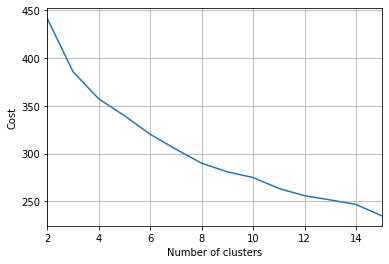

In [315]:
plot_cost_vs_clusters(X_weekly_mean_norm, max_clusters=15)

## Calculate clusters

In [319]:
n_clusters = 4

algorithm = KMeans
model = algorithm(n_clusters).fit(X_weekly_mean_norm.values)
clust = pd.Series(model.labels_, index=X_weekly_mean_norm.index)

## Plot Results

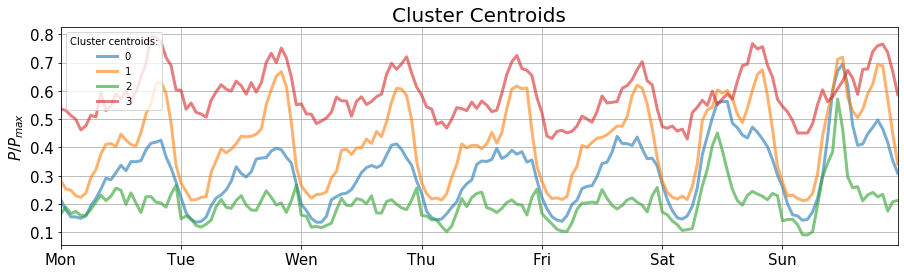

In [317]:
plot_cluster_centroids(X_weekly_mean_norm, clust, lw=3, alpha=0.6)

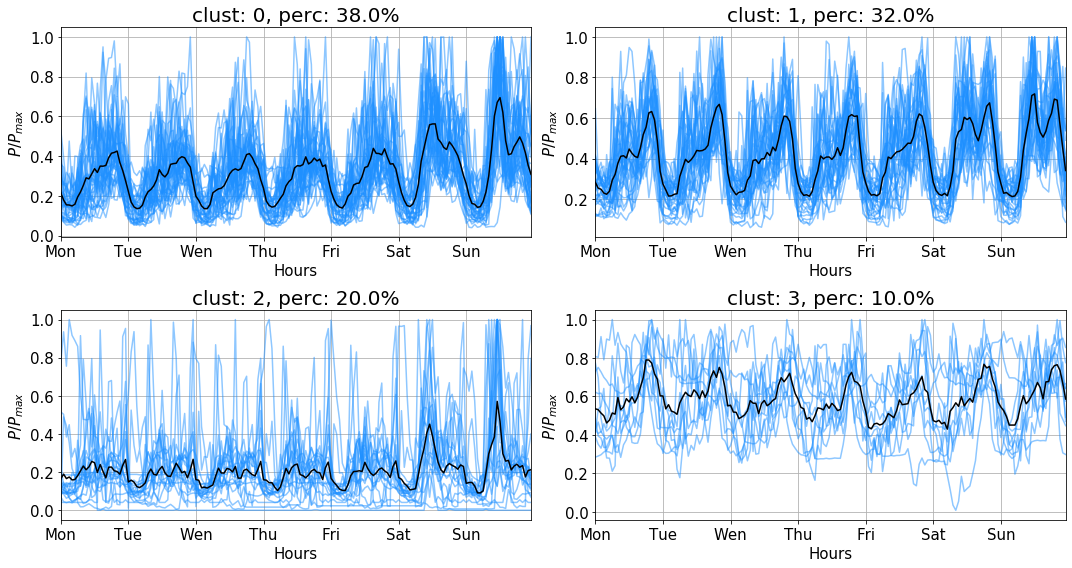

In [318]:
plot_clustered_profiles(X_weekly_mean_norm, clust, n_cols=2, alpha=0.5)